In [1]:
import sys
from pathlib import Path
from tqdm import tqdm
from shutil import copy, rmtree
import pandas as pd
from datasets import load_dataset
from numpy.random import choice

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/Texture-Anything/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare dataset for ControlNet training

##### ℹ️ This notebook requires the triplets `uv`, `caption` and `diffuse` for each dataset considered

In this notebook we move all the generated triplets to a single folder, compliant with `ImageFolder` dataset. See more at [Create an image dataset](https://huggingface.co/docs/datasets/image_dataset#imagefolder)

In [2]:
MAX_DATASET_SIZE = 10
TEST_SET_RATIO = 0.1
OUTPUT_PATH = Path("dataset").resolve()

In [3]:
datasets: list[Dataset3D] = [ObjaverseDataset3D()]

In [9]:
train_path = OUTPUT_PATH / "train"
test_path = OUTPUT_PATH / "test"
for path in [train_path, test_path]:
    rmtree(path)
    for folder in ["diffuse", "uv"]:
        (path / folder).mkdir(parents=True, exist_ok=True)

metadata = pd.DataFrame(columns=["uv_file_name", "diffuse_file_name", "caption", "split"])
for dataset in datasets:
    valid_uids = dataset.statistics["valid"].index
    avail_uids = dataset.triplets
    uids = list(avail_uids.intersection(valid_uids))
    if MAX_DATASET_SIZE:
        uids = uids[:MAX_DATASET_SIZE]
    train_uids = choice(uids, size=int(len(uids) * 0.9), replace=False)
    cprint(f"yellow:{dataset.__class__.__name__}", "has", len(avail_uids), "uids,", len(uids), "of them are valid.")

    uv_paths = {x.stem: x for x in (dataset.DATASET_PATH / "uv").glob("*") if x.suffix in dataset.IMG_EXT}
    diffuse_paths = {x.stem: x for x in (dataset.DATASET_PATH / "diffuse").glob("*") if x.suffix in dataset.IMG_EXT}
    captions = dataset.captions

    for uid in tqdm(uids):
        path = train_path if uid in train_uids else test_path
        copy(uv_paths[uid], path / "uv")
        copy(diffuse_paths[uid], path / "diffuse")
        metadata.loc[-1] = [
            "uv/" + uv_paths[uid].name,
            "diffuse/" + diffuse_paths[uid].name,
            captions[uid],
            "train" if uid in train_uids else "test",
        ]
        metadata.index += 1
metadata[metadata["split"] == "train"].drop(columns=["split"]).to_csv(train_path / "metadata.csv", index=False)
metadata[metadata["split"] == "test"].drop(columns=["split"]).to_csv(test_path / "metadata.csv", index=False)

ObjaverseDataset3D has 13,700 uids, 10 of them are valid.


100%|██████████| 10/10 [00:00<00:00, 136.76it/s]


In [10]:
size = sum(f.stat().st_size for f in train_path.glob("**/*") if f.is_file()) / (1 - TEST_SET_RATIO)
cprint("Dataset size:", size // 1024**2, "green:MiB")

Dataset size: 8.0 MiB


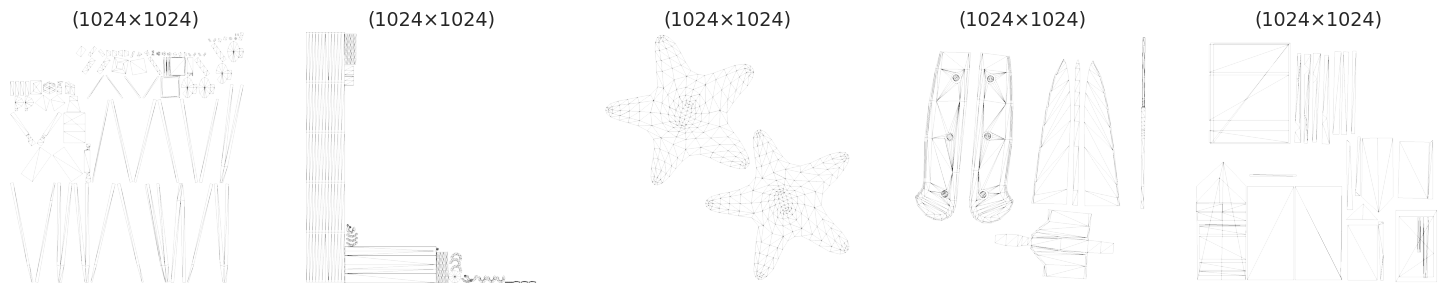

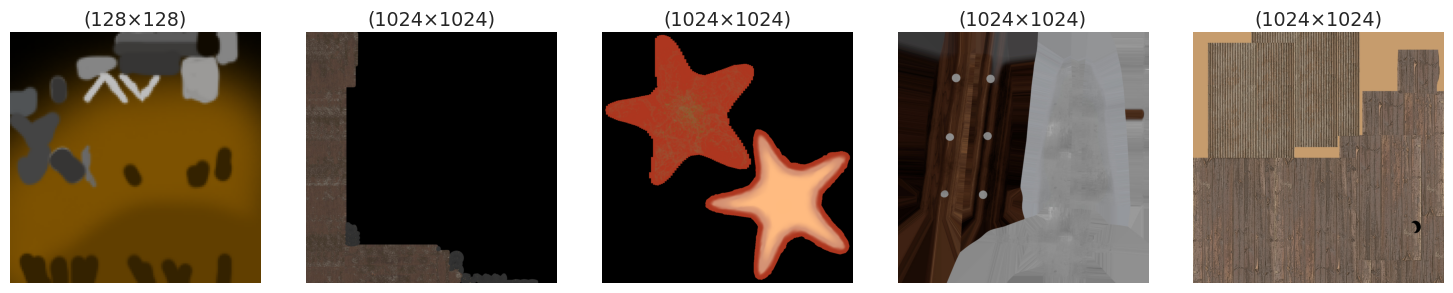

["a wooden tripod stands firmly, its base wide and sturdy, supporting a sleek, metallic camera with a matte finish. the camera's lens is round, and the tripod's legs are angled, ready to capture the world.",
 'a tall, slender wooden pole with a rough, textured surface and a dark brown color, topped with a simple, flat cross design.',
 'a vibrant red starfish with a textured surface, exhibiting a pattern of concentric circles and a slightly rough texture, suggesting a natural, marine environment.',
 'a sharp knife with a wooden handle and a clear blade, featuring a smooth metallic finish and a warm brown color.',
 'a rustic wooden birdhouse with a triangular roof, a small circular entrance, and a textured surface that suggests a natural, weathered appearance.']

In [15]:
dataset = load_dataset(str(OUTPUT_PATH))
plot_images(dataset["train"]["uv"][:5], size=3)
plot_images(dataset["train"]["diffuse"][:5], size=3)
dataset["train"]["caption"][:5]